# Grab our datasets to train the model

We will train on Cifar10 and other datasets, let's grab them and prepare them to train our Diffusion Model

In [113]:
import os, shutil, random
from types import SimpleNamespace
from pathlib import Path
import zipfile
import torch
from kaggle import api
import wandb
import torchvision
import torchvision.transforms as T
from PIL import Image
from fastdownload import FastDownload
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

## Helper funcs

In [114]:
def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [115]:
def untar_data(url, force_download=False, base='./datasets'):
    d = FastDownload(base=base)
    return d.get(url, force=force_download, extract_key='data')

In [116]:
def get_kaggle_dataset(dataset_path, # Local path to download dataset to
                dataset_slug, # Dataset slug (ie "zillow/zecon")
                unzip=True, # Should it unzip after downloading?
                force=False # Should it overwrite or error if dataset_path exists?
               ):
    '''Downloads an existing dataset and metadata from kaggle'''
    if not force and Path(dataset_path).exists():
        return Path(dataset_path)
    api.dataset_metadata(dataset_slug, str(dataset_path))
    api.dataset_download_files(dataset_slug, str(dataset_path))
    if unzip:
        zipped_file = Path(dataset_path)/f"{dataset_slug.split('/')[-1]}.zip"
        import zipfile
        with zipfile.ZipFile(zipped_file, 'r') as zip_ref:
            zip_ref.extractall(Path(dataset_path))
        zipped_file.unlink()

## Cifar

Our trusty Cifar dataset...

In [117]:
#cifar_labels = "airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck".split(",")
#Only select two classes for now
cifar_labels = "airplane,automobile".split(",")

In [118]:
def get_cifar(cifar100=False, img_size=64):
    "Download and extract CIFAR"
    cifar10_url = 'https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz'
    cifar100_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz'
    if img_size==32:
        return untar_data(cifar100_url if cifar100 else cifar10_url)
    else:
        get_kaggle_dataset("datasets/cifar10_64", "joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution")
        return Path("datasets/cifar10_64/cifar10-64")

In [119]:
path = get_cifar()

In [120]:
path

Path('datasets/cifar10_64/cifar10-64')

In [121]:
path.ls()

(#2) [Path('datasets/cifar10_64/cifar10-64/train'),Path('datasets/cifar10_64/cifar10-64/test')]

Let's log a version of the dataset to our project

In [122]:
at = wandb.Artifact("CIFAR10_64", type="dataset", 
                    description="The CIFAR10 datasets scaled to 64 pixels with 2 classes",  
                    metadata={"img_size":64, "url": "kaggle.com/joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution",
                              "labels":cifar_labels})

In [123]:
at.add_dir("datasets/cifar10_64/cifar10-64/")

wandb: Adding directory to artifact (./datasets/cifar10_64/cifar10-64)... Done. 24.2s


In [124]:
with wandb.init(project="train_sd", job_type="log_dataset"):
    wandb.log_artifact(at)

In [125]:
def get_cifar_data(dataset_path, img_size=64, batch_size=8, train_folder="train", val_folder="test", slice_size=-1, num_workers=4):
    train_transforms = torchvision.transforms.Compose([
        T.Resize(img_size + int(.25*img_size)),  # img_size + 1/4 *img_size
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    val_transforms = torchvision.transforms.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, train_folder), transform=train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, val_folder), transform=val_transforms)

    class0_indices_train = [i for i, (path, label) in enumerate(train_dataset.imgs) if label == 0]
    class1_indices_train = [i for i, (path, label) in enumerate(train_dataset.imgs) if label == 1]

    class0_indices_val = [i for i, (path, label) in enumerate(val_dataset.imgs) if label == 0]
    class1_indices_val = [i for i, (path, label) in enumerate(val_dataset.imgs) if label == 1]

    train_dataset_I = torch.utils.data.Subset(train_dataset, indices=class0_indices_train)
    val_dataset_I = torch.utils.data.Subset(val_dataset, indices=class0_indices_val)

    train_dataset_F = torch.utils.data.Subset(train_dataset, indices=class1_indices_train)
    val_dataset_F = torch.utils.data.Subset(val_dataset, indices=class1_indices_val)
    
    if slice_size>1:
        train_dataset_I = torch.utils.data.Subset(train_dataset_I, indices=range(0, len(train_dataset_I), slice_size))
        val_dataset_I = torch.utils.data.Subset(val_dataset_I, indices=range(0, len(val_dataset_I), slice_size))

        train_dataset_F = torch.utils.data.Subset(train_dataset_F, indices=range(0, len(train_dataset_F), slice_size))
        val_dataset_F = torch.utils.data.Subset(val_dataset_F, indices=range(0, len(val_dataset_F), slice_size))
    
    print(f"Train dataset Initial: {len(train_dataset_I)} images")
    print(f"Val dataset Initial: {len(val_dataset_I)} images")
    print(f"Train dataset Final: {len(train_dataset_F)} images")
    print(f"Val dataset Final: {len(val_dataset_F)} images")


    train_dataloader_I = DataLoader(train_dataset_I, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    val_dataset_I = DataLoader(val_dataset_I, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    train_dataloader_F = DataLoader(train_dataset_F, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    val_dataset_F = DataLoader(val_dataset_F, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_dataloader_I, val_dataset_I, train_dataloader_F, val_dataset_F

Let's get a sample of 1/100th the total dataset... around 600/100 images

In [126]:
train_dl_i, val_dl_i, train_dl_f, val_dl_f  = get_cifar_data(path, batch_size=256, slice_size=100)

Train dataset Initial: 50 images
Val dataset Initial: 10 images
Train dataset Final: 50 images
Val dataset Final: 10 images


In [127]:
x,_ = next(iter(train_dl_i))
y,_ = next(iter(train_dl_f))
x.shape, y.shape

(torch.Size([50, 3, 64, 64]), torch.Size([50, 3, 64, 64]))

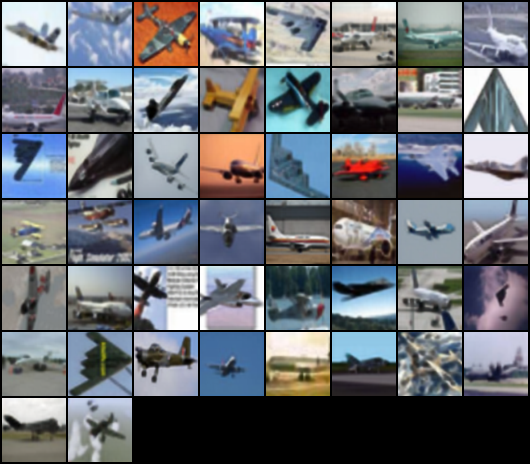

In [128]:
wandb.Image(x).image

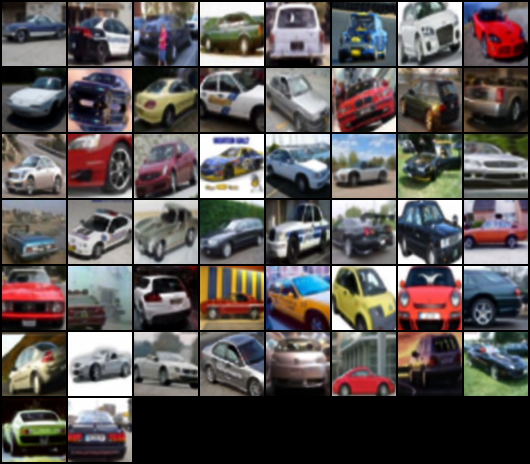

In [129]:
 wandb.Image(y).image

create a wandb.Table

In [130]:
table = wandb.Table(columns=["I_image", "I_label", "F_image", "F_label", "split"])

In [131]:
for (img_i,label_i), (img_f,label_f) in iter(zip(train_dl_i.dataset, train_dl_f.dataset)):
    table.add_data(wandb.Image(img_i), label_i, wandb.Image(img_f), label_f, "train")

In [132]:
for (img_i,label_i), (img_f,label_f) in iter(zip(val_dl_i.dataset, val_dl_f.dataset)):
    table.add_data(wandb.Image(img_i), label_i, wandb.Image(img_f), label_f, "valid")

log the table

In [136]:
with wandb.init(project="train_sd", group="cifar10", job_type="dataset_viz"):
    wandb.use_artifact('CIFAR10_64:v1', type='dataset')
    wandb.log({"cifar_viz":table})